In [1]:
# Astronomy 400B
# Homework 5
# Mass and Velocity Profiles of MW, M31, and M33
# Marco Barragan

In [3]:
# Import modules
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import astropy.units as u
import astropy.table as tbl
from astropy.constants import G
from ReadFile import Read
from CenterofMass import CenterOfMass

In [4]:
# Gravitational constant in units of kpc/Msun * (km/s)**2
G = G.to(u.kpc*u.km**2/u.s**2/u.Msun)
G

<Quantity 4.30091727e-06 km2 kpc / (s2 solMass)>

In [5]:
class MassProfile:
    # Inputs:
    #    Galaxy name (ex: "MW" for Milky Way)
    #    Snapshot number (ex: 0 for a file MW_000.txt)
    
    def __init__(self, galaxy, snap):
        # Initialize the instance of this Class with the following properties:
    
        # Add a string of the filenumber to "000"
        ilbl = '000' + str(snap)
        # Remove all but the last 3 digits
        ilbl = ilbl[-3:]
        self.filename = "%s_"%(galaxy) + ilbl + '.txt'

        # Read data in the given file using Read
        self.time, self.total, self.data = Read(self.filename)                                                                                             

        # Store the mass, positions of only the particles of the given type
        self.m = self.data['m']
        self.x = self.data['x']
        self.y = self.data['y']
        self.z = self.data['z']
        
        # Store the galaxy name
        self.gname = galaxy
    
    # Compute the mass enclosed of a certain object type within a certain radius from the COM
    def MassEnclosed(self,ptype,r):
        # Inputs:
        #    ptype = particle type (1=Halo,2=Disk,3=Bulge)
        #    r is the distance from the Galactic center (kpc)
        # Returns:
        #    Array of mass enclosed within each element in r (Msun)
        
        # Store the center of mass position
        COM = CenterOfMass(self.filename, 2)
        COMP = COM.COM_P(0.1)
        
        # Make a new coordinates with respect to the center of mass
        xNew = self.x - COMP[0].value
        yNew = self.y - COMP[1].value
        zNew = self.z - COMP[2].value
        rNew = np.sqrt(xNew**2 + yNew**2 + zNew**2)
        
        # Filter out other particle types
        PTypeIndex = np.where(self.data['type'] == ptype)
        
        # Radius of all particles of ptype
        rNewer = rNew[PTypeIndex]
        
        # Initialize mass array
        MEnclosed = np.zeros(len(r))
        
        for i in range(len(r)):
            # Filter out radii that are greater than r
            RIndex = np.where(rNewer <= r[i])
            
            # Sum all masses within r
            MEnclosed[i] = np.sum(self.m[PTypeIndex][RIndex])
           
        
        return MEnclosed * 1e10 * u.solMass 
    
    # Compute total mass within a radius from all components
    def MassEnclosedTotal(self,r):
        # Inputs:
        #    r is the distance from the Galactic center (kpc)
        # Returns:
        #    Array of mass enclosed within each element in r (Msun)
        
        # Initialize
        Mass = np.zeros([3,len(r)])
        MassTotal = np.zeros(len(r))
        
        for i in range(3):
            # Store Mass for each ptype
            Mass[i] = self.MassEnclosed(i+1,r)
            # Since we initialized this to hav an array of zeroes, we don't
            # need to specify if there is or isn't a certain ptype 
            # (ex: M33 has no bulge ptype=3)
        
        # Transpose array in order to sum a row coresponding to each r
        MassT = Mass.transpose()
            
        for i in range(len(r)):    
            # Sum mass of all 3 components
            MassTotal[i] = np.sum(MassT[i])
                
        return MassTotal * u.solMass 
    
    
    # Create a function that returns Hernquist 1990 Mass Profile
    # M = Mhalo * r^2/(a+r)^2
    def HernquistM(self,r,a,Mhalo):
        # Input:
        #    r is the distance from the Galactic center (kpc)
        #    a is the scale radius (default of 60) (kpc)
        #    Mhalo is the total mass of the dark matter halo (default is 1.97 from HW3) (1e12 * Msun)
        # Returns:
        #    Total dark matter mass enclosed withing radius r (Msun)
    
        HernqMass = Mhalo * r**2 / (a + r)**2
    
        return HernqMass * 1e12 * u.Msun
    
    
    # Compute circular velocity of a particle type within a radius r
    # v^2 = GM/R
    def CircularVelocity(self,ptype,r):
        # Inputs:
        #    ptype = particle type (1=Halo,2=Disk,3=Bulge)
        #    r is the distance from the Galactic center (kpc)
        # Returns:
        #    Array of circular velocity enclosed within each element in r (km/s)
        
        # Store mass enclosed within r
        MEnclosed = self.MassEnclosed(ptype,r)
        
        # Compute Velocity enclosed within r using expression above
        VEnclosed = np.sqrt(G.value*MEnclosed.value/r)
        
        return np.around(VEnclosed,2)*u.km/u.s
            
    
    # Compute circular velocity from all particle types
    def CircularVelocityTotal(self,r):
        # Inputs:
        #    r is the distance from the Galactic center (kpc)
        # Returns:
        #    Array of mass enclosed within each element in r (Msun)
        
        # Store total Mass enclosed within r
        MTotal = self.MassEnclosedTotal(r)
        
        # Compute Velocity enclosed within r using expression above
        VTotal = np.sqrt(G.value*MTotal.value/r)
        
        return np.around(VTotal,2) * u.km / u.s
    
    
    # Create a function that returns a Velocity Profile from the Hernquist Mass
    def HernquistVCirc(self,r,a,Mhalo):
        # Input:
        #    r is the distance from the Galactic center (kpc)
        #    a is the scale radius (default of 60) (kpc)
        #    Mhalo is the total mass of the dark matter halo (default is 1.97 from HW3) (1e12 * Msun)
        # Returns:
        #    Total dark matter mass enclosed withing radius r (km/s)
    
        # Store total Mass enclosed within r
        MHernq = self.HernquistM(r,a,Mhalo)
        
        # Compute Velocity enclosed within r using expression above
        VHernq = np.sqrt(G.value*MHernq.value/r)
        
        return VHernq * u.km / u.s

In [6]:
# Define Mass profiles for each galaxy
MW = MassProfile("MW",0)
M31 = MassProfile("M31",0)
M33 = MassProfile("M33",0)

In [7]:
# Define radius as array from ~0 kpc to 30 kpc
r = np.arange(0.0001,30.0,0.01)

# Mass Profile Plots--------------------------------------

## MW

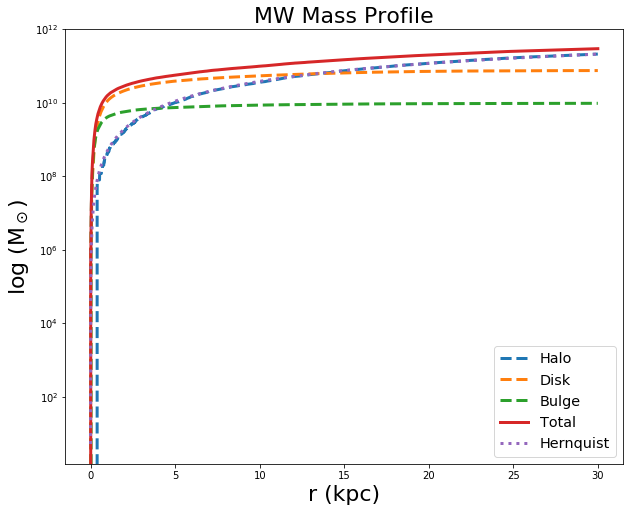

In [8]:
fig,ax = plt.subplots(figsize=(10,8))

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Plot 
plt.semilogy(r, MW.MassEnclosed(1,r), '--', linewidth=3, label='Halo')
plt.semilogy(r, MW.MassEnclosed(2,r), '--', linewidth=3, label='Disk')
plt.semilogy(r, MW.MassEnclosed(3,r), '--', linewidth=3, label='Bulge')
plt.semilogy(r, MW.MassEnclosedTotal(r), linewidth=3, label='Total')
plt.semilogy(r, MW.HernquistM(r,a=62,Mhalo=1.975), ':', linewidth=3, label='Hernquist')

# Axes labels 
plt.title('MW Mass Profile',fontsize=22)
plt.xlabel('r (kpc)',fontsize=22) 
plt.ylabel('log (M$_\odot$)', fontsize=22)

# Legend
plt.legend(loc='lower right',fontsize='x-large')

## M31

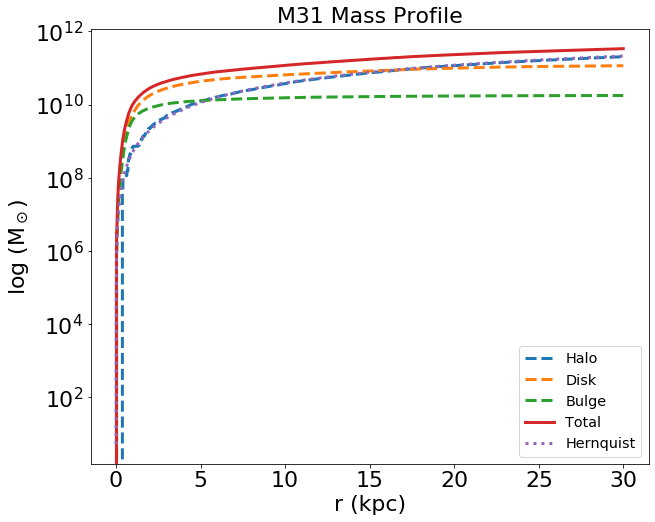

In [9]:
fig,ax = plt.subplots(figsize=(10,8))

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Plot 
plt.semilogy(r, M31.MassEnclosed(1,r), '--', linewidth = 3, label='Halo')
plt.semilogy(r, M31.MassEnclosed(2,r), '--', linewidth = 3, label='Disk')
plt.semilogy(r, M31.MassEnclosed(3,r), '--', linewidth = 3, label='Bulge')
plt.semilogy(r, M31.MassEnclosedTotal(r), linewidth = 3, label='Total')
plt.semilogy(r, M31.HernquistM(r,a=60,Mhalo=1.921), ':', linewidth = 3, label='Hernquist')

# Axes labels 
plt.title('M31 Mass Profile',fontsize=22)
plt.xlabel('r (kpc)',fontsize=22) 
plt.ylabel('log (M$_\odot$)', fontsize=22)

# Legend
plt.legend(loc='lower right',fontsize='x-large')

## M33

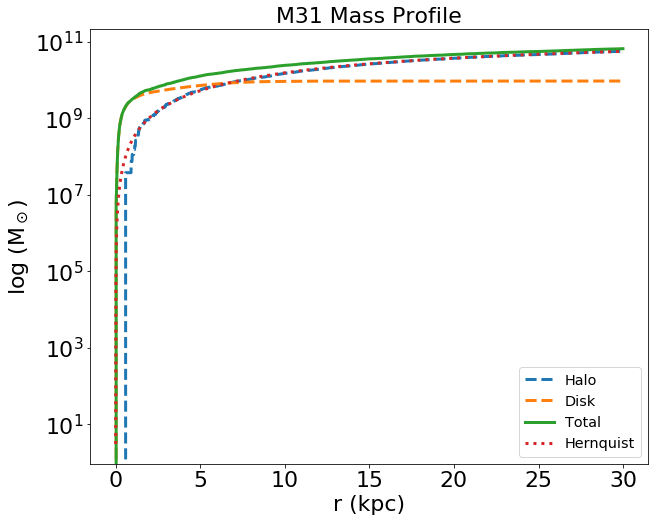

In [10]:
fig,ax = plt.subplots(figsize=(10,8))

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Plot 
plt.semilogy(r, M33.MassEnclosed(1,r), '--', linewidth = 3, label='Halo')
plt.semilogy(r, M33.MassEnclosed(2,r), '--', linewidth = 3, label='Disk')
plt.semilogy(r, M33.MassEnclosedTotal(r), linewidth = 3, label='Total')
plt.semilogy(r, M33.HernquistM(r,a=25,Mhalo=0.187), ':', linewidth = 3, label='Hernquist')

# Axes labels 
plt.title('M31 Mass Profile',fontsize=22)
plt.xlabel('r (kpc)',fontsize=22) 
plt.ylabel('log (M$_\odot$)', fontsize=22)

# Legend
plt.legend(loc='lower right',fontsize='x-large')

# Rotation Curve Plots ----------------------------------------

## MW

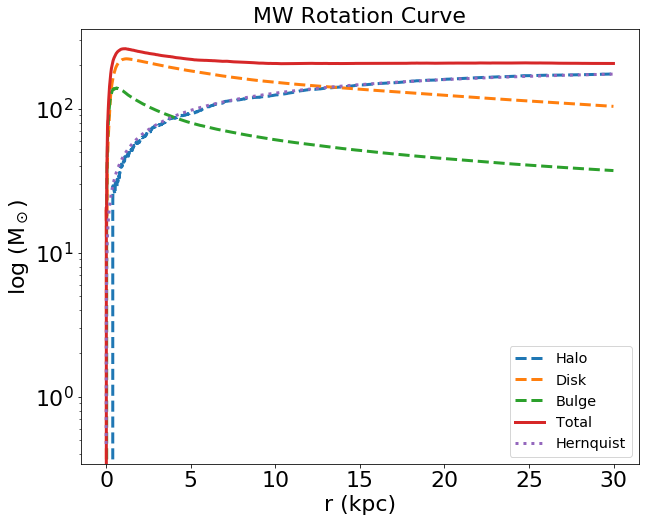

In [11]:
fig,ax = plt.subplots(figsize=(10,8))

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Plot 
plt.semilogy(r, MW.CircularVelocity(1,r), '--', linewidth=3, label='Halo')
plt.semilogy(r, MW.CircularVelocity(2,r), '--', linewidth=3, label='Disk')
plt.semilogy(r, MW.CircularVelocity(3,r), '--', linewidth=3, label='Bulge')
plt.semilogy(r, MW.CircularVelocityTotal(r), linewidth=3, label='Total')
plt.semilogy(r, MW.HernquistVCirc(r,a=62,Mhalo=1.975), ':', linewidth=3, label='Hernquist')

# Axes labels 
plt.title('MW Rotation Curve',fontsize=22)
plt.xlabel('r (kpc)',fontsize=22) 
plt.ylabel('log (M$_\odot$)', fontsize=22)

# Legend
plt.legend(loc='lower right',fontsize='x-large')

## M31

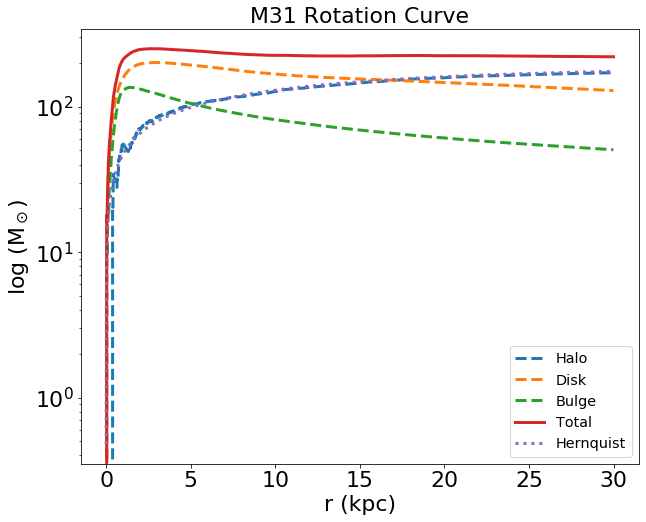

In [12]:
fig,ax = plt.subplots(figsize=(10,8))

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Plot 
plt.semilogy(r, M31.CircularVelocity(1,r), '--', linewidth = 3, label='Halo')
plt.semilogy(r, M31.CircularVelocity(2,r), '--', linewidth = 3, label='Disk')
plt.semilogy(r, M31.CircularVelocity(3,r), '--', linewidth = 3, label='Bulge')
plt.semilogy(r, M31.CircularVelocityTotal(r), linewidth = 3, label='Total')
plt.semilogy(r, M31.HernquistVCirc(r,a=60,Mhalo=1.921), ':', linewidth = 3, label='Hernquist')

# Axes labels 
plt.title('M31 Rotation Curve',fontsize=22)
plt.xlabel('r (kpc)',fontsize=22) 
plt.ylabel('log (M$_\odot$)', fontsize=22)

# Legend
plt.legend(loc='lower right',fontsize='x-large')

## M33

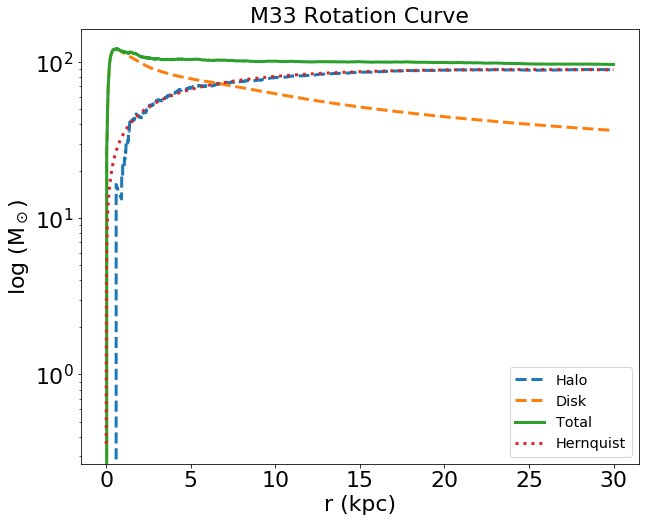

In [13]:
fig,ax = plt.subplots(figsize=(10,8))

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Plot 
plt.semilogy(r, M33.CircularVelocity(1,r), '--', linewidth = 3, label='Halo')
plt.semilogy(r, M33.CircularVelocity(2,r), '--', linewidth = 3, label='Disk')
plt.semilogy(r, M33.CircularVelocityTotal(r), linewidth = 3, label='Total')
plt.semilogy(r, M33.HernquistVCirc(r,a=25,Mhalo=0.187), ':', linewidth = 3, label='Hernquist')

# Axes labels 
plt.title('M33 Rotation Curve',fontsize=22)
plt.xlabel('r (kpc)',fontsize=22) 
plt.ylabel('log (M$_\odot$)', fontsize=22)

# Legend
plt.legend(loc='lower right',fontsize='x-large')